# Graphing Duke PhD Committee Interdisciplinary Connections

#### Imports and other setup

set_node_attributes was not working for me with networkx 2.0 [see issue here](https://github.com/USEPA/WNTR/issues/29), so downgraded to 1.11 to get it running.

In [1]:
import math
from itertools import cycle
import pandas as pd
import numpy as np
import networkx as nx
from visJS2jupyter import visJS_module
import community
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from operator import itemgetter
import operator

# For display purposes
%matplotlib inline
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 800)

#### Setup paths, "global" variables, etc

In [2]:
edges_path = '../outputs/edges.csv'
orgs_path = '../outputs/org_names.csv'
output_path = './'
debug = False
# my_nrows = 200 # for testing
my_nrows = None # run on all rows

#### Define custom color functions for good discrete node colors, min / max edge colors  
It has to be in this weird string format for visJS2jupyter. See `return_node_to_color()` in [visJS_module.py](https://pypkg.com/pypi/visjs2jupyter/f/visJS2jupyter/visJS_module.py) for the normal method  

In [3]:
def my_node_to_color(G,field_to_map='degree'):
    nodes_with_data = [(n[0], max(n[1][field_to_map], 0)) for n in G.nodes(data=True)]

    nsteps=20
    color_order=[0,2,4,6,8,10,12,14,16,18,1,3,5,7,9,11,13,15,17,19]
    cmap=plt.get_cmap("tab20")
    alpha = 1.0
    
    color_list_raw = cmap(np.linspace(0, 1, nsteps)) 
  
    nodes,data = zip(*nodes_with_data)
    data = [color_order[d] for d in data]
    nodes_with_data = zip(nodes,data)

    node_to_mapField = dict(nodes_with_data)
    color_list = [color_list_raw[node_to_mapField[d]] for d in G.nodes()]
    
    color_list = [(int(256*c[0]),int(256*c[1]),int(256*c[2]),alpha) for c in color_list]
    node_to_color = dict(zip(list(G.nodes()),['rgba'+str(c) for c in color_list]))

    return node_to_color

In [4]:
def my_edge_to_color(G,field_to_map='degree',cmap=plt.cm.jet,alpha = 1.0,color_vals_transform = None,ceil_val=10,
                         color_max_frac = 1.0,color_min_frac = 0.0):
    # check whether it is a multigraph or not
    if (str(type(G)) == '<class \'networkx.classes.multigraph.MultiGraph\'>'):
        G_edges = G.edges(keys = True, data=True)
        edges_with_data = [(e[0],e[1],e[2],e[3][field_to_map]) for e in G_edges]
        edges1,edges2,edges3, data = zip(*edges_with_data)
    else:
        G_edges = G.edges(data=True)
        edges_with_data = [(e[0],e[1],e[2][field_to_map]) for e in G_edges]
        edges1,edges2,data = zip(*edges_with_data)
    # perform data transformations if necessaary
    if color_vals_transform == 'log':
        nonzero_list = [d for d in data if d>(10**-18)]
        if not nonzero_list:
            data = [1 for d in data]
        else:
            min_dn0 = min([d for d in data if d>(10**-18)])
            data = [np.log(max(d,min_dn0)) for d in data]  # set the zero d values to minimum non0 value
            data = [(d-np.min(data)) for d in data] # shift so we don't have any negative values
    elif color_vals_transform == 'sqrt':
        data = [np.sqrt(d) for d in data]
    elif color_vals_transform == 'ceil':
        data = [max(d,ceil_val) for d in data]
    # check whether it is a multigraph or not
    if (str(type(G)) == '<class \'networkx.classes.multigraph.MultiGraph\'>'):
        edges_with_data = zip(zip(edges1,edges2,edges3),data)
        G_edges = G.edges(keys = True)
    else:
        G_edges = G.edges()
        edges_with_data = zip(zip(edges1,edges2),data)
    
    color_to_mult = 256*(color_max_frac-color_min_frac)
    color_to_add = 256*color_min_frac

    edge_to_mapField = dict(edges_with_data)
#    color_list = [np.multiply(cmap(int(float(edge_to_mapField[d])/np.max(list(edge_to_mapField.values()))*256)),256) for d in G_edges]
    color_list = [np.multiply(cmap(int(float(edge_to_mapField[d])/np.max(list(edge_to_mapField.values()))*color_to_mult+color_to_add)),256) for d in G_edges]
    color_list = [(int(c[0]),int(c[1]),int(c[2]),alpha) for c in color_list]
    
    edge_to_color = dict(zip(list(G_edges),['rgba'+str(c) for c in color_list]))
    return edge_to_color


Define function to convert visJS text colors to regular plt colot tuples

In [5]:
def color_str_to_tuple(color_str):
    color_str = color_str.replace('rgba','')
    color_tuple_raw = literal_eval(color_str)
    color_tuple = [x / 256.0 for x in color_tuple_raw[:3]]
    color_tuple.append(color_tuple_raw[3])
    return color_tuple

Convert between visJS and matplotlib symbol names

In [6]:
visJS_to_mpl_symbol={
'dot':'o',
'square':'s',
'triangleDown':'v',
'triangle':'^',
'diamond':'D',
'star':'*'
}

#### Read in human readable names, create usable dicts / symbols of them

In [7]:
df_org = pd.read_csv(orgs_path, dtype={
'ORGANIZATIONAL_UNIT': int,
'SCHOOL_NAME': object,
'ORG_DISPLAY_NAME': object
})
df_org_index = df_org.set_index('ORGANIZATIONAL_UNIT')

df_org_names = df_org_index[['ORG_DISPLAY_NAME']]
org_names = df_org_names.to_dict()['ORG_DISPLAY_NAME']

df_school_names = df_org_index[['SCHOOL_NAME']]
school_names = df_school_names.to_dict()['SCHOOL_NAME']

# Autogenerate
#school_names_list = list(df_org_index['SCHOOL_NAME'].unique())
#symbol_list = ["dot", "diamond", "star", "triangle", "triangleDown", "square"]
#school_symbols = {k: v for k, v in zip(school_names_list, cycle(symbol_list))}

# just hard code to group up rarer ones
school_symbols={
 'Trinity College of Arts & Sciences': 'dot',
 'Pratt School of Engineering': 'square',
 'School of Medicine': 'triangleDown',
 'School of Nursing': 'triangle',
 'Nicholas School of the Environment': 'diamond',
 "Institutes and Provost's Academic Units": 'star',
 'Sanford School of Public Policy': 'star',
 'Divinity School': 'star',
 'Duke Law School': 'star',
 'Fuqua School of Business': 'star'
}

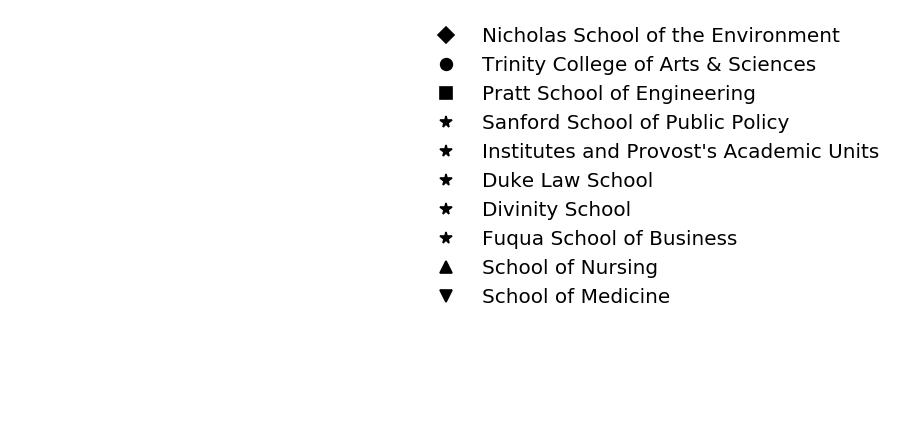

In [8]:
plt.figure(figsize=(9, 4), dpi=120, facecolor='w', edgecolor='k')
plt.axis("off")

leg_objects = []
for key, value in sorted(school_symbols.items(), key=operator.itemgetter(1)):
    leg_objects.append(plt.Line2D([0],[0],ls='None',marker=visJS_to_mpl_symbol[value],ms=7.0,label=key,c='black'))

leg = plt.legend(leg_objects, [ob.get_label() for ob in leg_objects], fontsize='large', borderaxespad=0.0)
leg.get_frame().set_edgecolor('white')
leg.get_frame().set_facecolor('white')
plt.show()

#### Read in edges from csv

In [9]:
if debug:
    if(my_nrows is not None): print "Reading first %d rows of %s" % (my_nrows, edges_path)
    else: print "Reading all rows of %s" % (edges_path)
# need to specify dtypes manually when reading many rows...
# otherwise pandas wants to try to load all the rows into memory before inferring the dtype and you get a warning
df_edges = pd.read_csv(edges_path, dtype={
'Date': object,
'n1': int,
'n2': int
} , nrows=my_nrows)

#### Build graph G up explicitly, edge by edge. This way we can get the weights correct

In [10]:
G = nx.Graph()
default_weight = 1.0
#default_weight = 1.0 / float(len(df_edges.index))
for index, row in df_edges.iterrows():
    n1 = row['n1']
    n2 = row['n2']
    if G.has_edge(n1,n2):
        G[n1][n2]['weight'] += default_weight
    else:
        G.add_edge(n1,n2, weight=default_weight)

### Create positions using the Fruchterman-Reingold force-directed / spring algorithm

In [11]:
spring_pos = nx.spring_layout(G,k=4/math.sqrt(nx.number_of_nodes(G))) # 1/sqrt(n) is the default spacing par

### Create partitions / communities using the Louvain Method

In [12]:
parts = community.best_partition(G)
nx.set_node_attributes(G, 'parts', parts) 

### Draw interactive graph!

In [13]:
nodes = G.nodes()
# node_to_color = visJS_module.return_node_to_color(G,field_to_map='parts',cmap=plt.get_cmap("jet"))
node_to_color = my_node_to_color(G,field_to_map='parts')

nodes_dict = [{"id":n,
               "title":("%s - %s" % (org_names[n],school_names[n])),
               #"title":org_names[n],
              "x":spring_pos[n][0]*1000,
              "y":spring_pos[n][1]*1000,
              #"color":"black",
              "color":node_to_color[n], 
               "node_shape":school_symbols[school_names[n]]
              } for n in nodes]
node_map = dict(zip(nodes,range(len(nodes)))) # map to indices for source/target in edges

In [14]:
edges_list = list(G.edges())
# edge_to_color = visJS_module.return_edge_to_color(G,field_to_map='weight', cmap=plt.cm.Greys,alpha = 1,color_vals_transform='log')
edge_to_color = my_edge_to_color(G,field_to_map='weight',cmap=plt.cm.Greys,alpha = 1,color_vals_transform='log',color_max_frac = 1.0,color_min_frac = 0.15)
edges_dict = [{"source":node_map[edges_list[i][0]],
               "target":node_map[edges_list[i][1]],
               "title":"A",
               "edge_title_field":"B",
               "edge_label_field":"C",
               "color":edge_to_color[edges_list[i]] 
              }for i in range(len(edges_list))]

In [15]:
visJS_module.visjs_network(nodes_dict,edges_dict,
                           node_size_multiplier=8,node_font_size=0,
                           edge_width=9,
                           tooltip_delay = 0,
                           graph_width = 900,
                           graph_height = 700,
                           graph_id = 0,
                           config_enabled=False)

### List the members of the communities

In [16]:
df_communities = pd.DataFrame(parts.items(), columns=['ORGANIZATIONAL_UNIT', 'Community'])

In [17]:
## Pandas dataframe way
#from collections import defaultdict
#columns = defaultdict(list)
#for community in df_communities.Community.unique():
#        df_community = df_communities[df_communities['Community']==community]
#        for node in list(df_community['ORGANIZATIONAL_UNIT']):
#            columns[community].append(node)
#print columns
#df_community_lists = pd.DataFrame(dict([(col_name,pd.Series(values)) for col_name,values in columns.items() ]))
#df_community_lists

In [18]:
## Raw text
#for community in df_communities.Community.unique():
#        print community
#        df_community = df_communities[df_communities['Community']==community]
#        for n in list(df_community['ORGANIZATIONAL_UNIT']):
#            print "%s - %s" % (org_names[n],school_names[n])

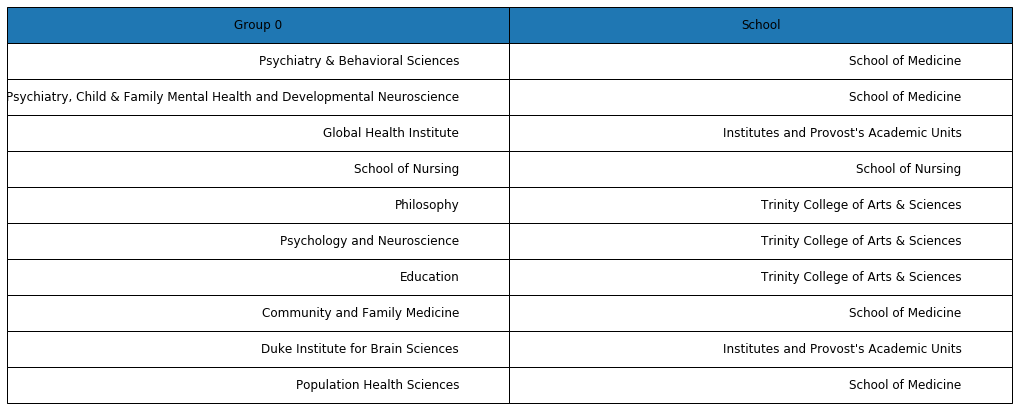

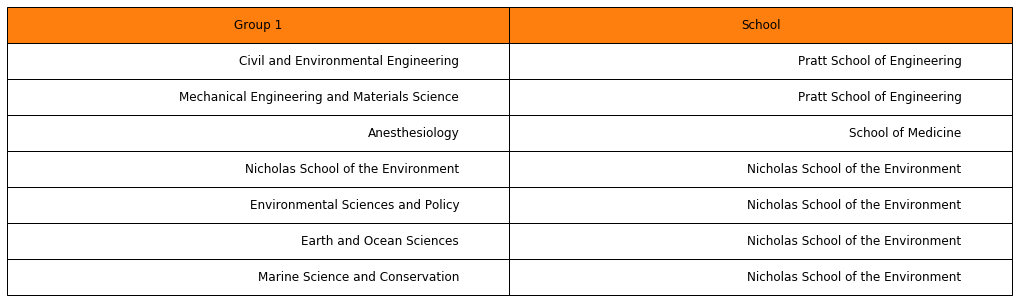

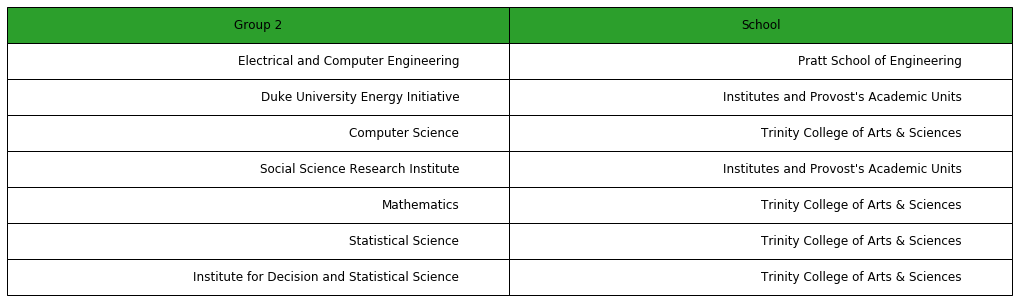

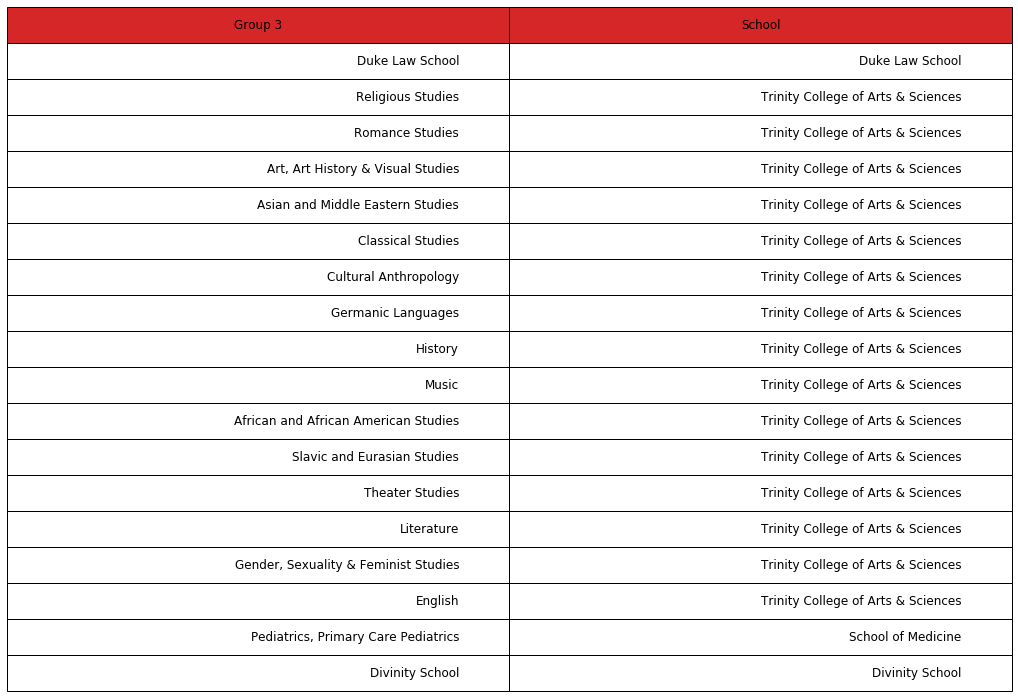

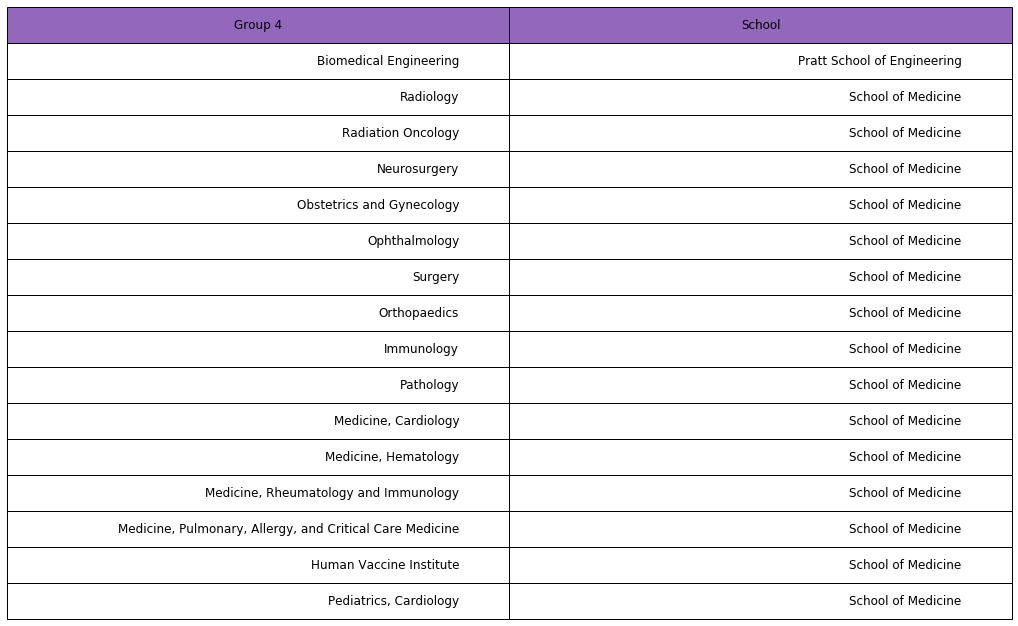

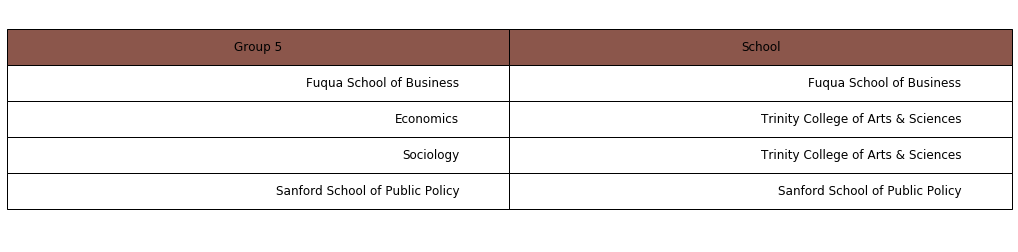

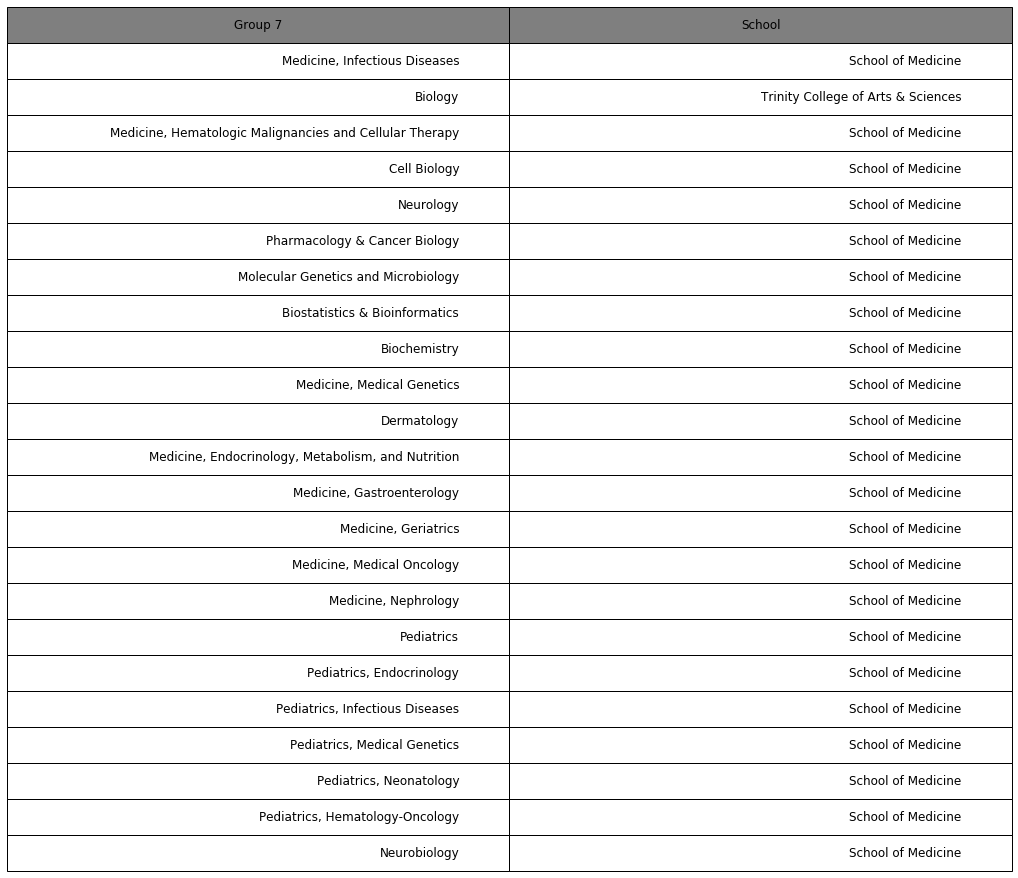

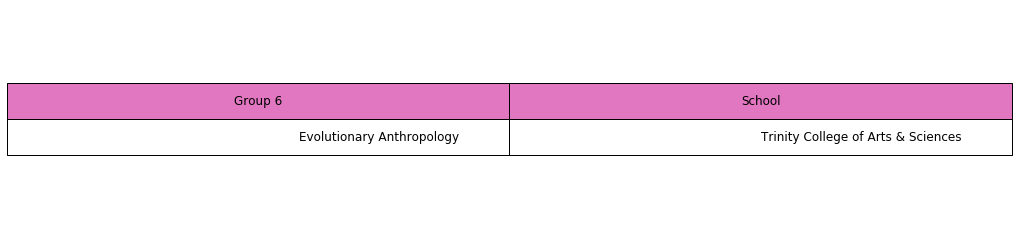

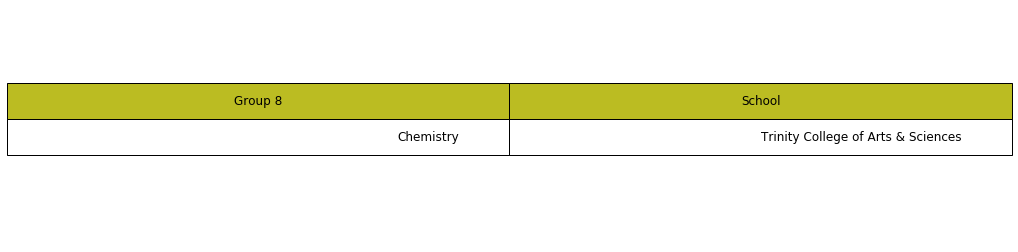

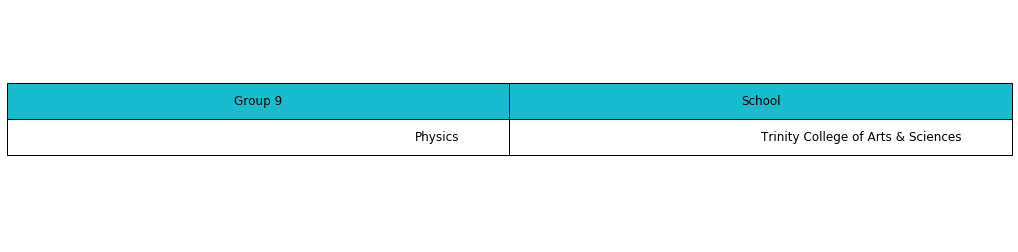

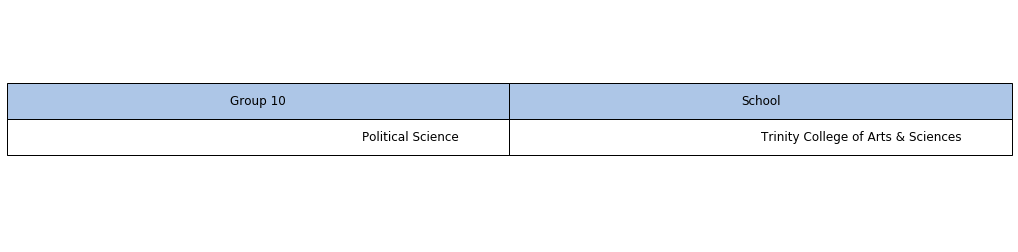

In [19]:
## As matplotlib tables, with color coded headers
from ast import literal_eval
for community in df_communities.Community.unique():
    df_community = df_communities[df_communities['Community']==community]
    cell_text = []
    first_n = -1
    for n in list(df_community['ORGANIZATIONAL_UNIT']):
        # cell_text.append([("%s - %s" % (org_names[n],school_names[n]))])
        cell_text.append([org_names[n], school_names[n]])
        if first_n == -1: first_n = n

    color_tuple = color_str_to_tuple(node_to_color[first_n])

    plt.axis('off')
    the_table = plt.table(cellText=cell_text,colLabels=[("Group %d" % community),"School"],
              colColours=[color_tuple,color_tuple],
              loc='center')
    the_table.scale(3,3)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    plt.show()

In [20]:
#interact slider demo for later
def f(x):
    return x
interact(f, x=10);


interactive(children=(IntSlider(value=10, description=u'x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

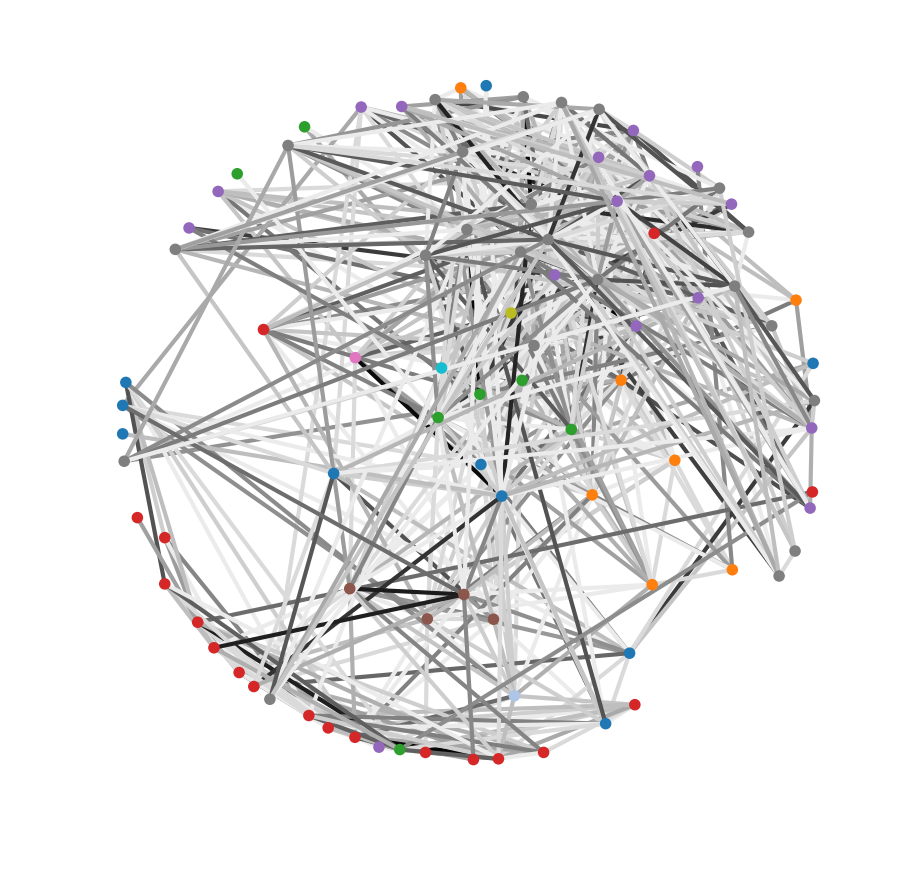

In [27]:
plt.figure(figsize=(9, 9), dpi=120, facecolor='w', edgecolor='k')
plt.axis("off")
nx.draw_networkx(G,
                 pos=spring_pos,
                 node_color=[color_str_to_tuple(value) for key, value in node_to_color.iteritems()],
                 node_size=35,
                 with_labels=False,
                 width=2.5,
                 edge_color=[color_str_to_tuple(value) for key, value in edge_to_color.iteritems()]
                )
plt.show()

### Stats of graph

In [22]:
print nx.info(G)
print "Density: %.4f" % (nx.density(G))
print "Triadic closure: %.4f" % (nx.transitivity(G))
print "Diameter: %d" % (nx.diameter(G))

Name: 
Type: Graph
Number of nodes: 89
Number of edges: 746
Average degree:  16.7640
Density: 0.1905
Triadic closure: 0.4769
Diameter: 5


### Centrality

In [23]:
degree_dict = G.degree(G.nodes())
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print "Top 10% of nodes by degree:"
for d in sorted_degree[:int(0.1*len(sorted_degree))]:
    print "%d, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])

Top 10% of nodes by degree:
48, Biomedical Engineering - Pratt School of Engineering
44, Molecular Genetics and Microbiology - School of Medicine
43, Pharmacology & Cancer Biology - School of Medicine
42, Biology - Trinity College of Arts & Sciences
40, Medicine, Cardiology - School of Medicine
36, Surgery - School of Medicine
33, Statistical Science - Trinity College of Arts & Sciences
33, Cell Biology - School of Medicine


In [24]:
eigenvector_dict = nx.eigenvector_centrality(G)
#nx.set_node_attributes(G, 'eigenvector', eigenvector_dict)
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)
print "Top 10% of nodes by eigenvector:"
for d in sorted_eigenvector[:int(0.1*len(sorted_eigenvector))]:
    print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])

Top 10% of nodes by eigenvector:
0.5435, Electrical and Computer Engineering - Pratt School of Engineering
0.3975, Physics - Trinity College of Arts & Sciences
0.3931, Biomedical Engineering - Pratt School of Engineering
0.2862, Chemistry - Trinity College of Arts & Sciences
0.2725, Biology - Trinity College of Arts & Sciences
0.1882, Pharmacology & Cancer Biology - School of Medicine
0.1840, Biochemistry - School of Medicine
0.1750, Computer Science - Trinity College of Arts & Sciences


In [25]:
betweenness_dict = nx.betweenness_centrality(G)
#nx.set_node_attributes(G, 'betweenness', betweenness_dict)
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
print "Top 10% of nodes by betweenness:"
for d in sorted_betweenness[:int(0.1*len(sorted_betweenness))]:
    print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])

Top 10% of nodes by betweenness:
0.1014, Psychology and Neuroscience - Trinity College of Arts & Sciences
0.0631, Biology - Trinity College of Arts & Sciences
0.0621, Biomedical Engineering - Pratt School of Engineering
0.0586, Statistical Science - Trinity College of Arts & Sciences
0.0564, Environmental Sciences and Policy - Nicholas School of the Environment
0.0529, History - Trinity College of Arts & Sciences
0.0484, Sociology - Trinity College of Arts & Sciences
0.0476, Physics - Trinity College of Arts & Sciences


In [26]:
frac_dict = {}
for node in nodes:
    edges = G.edges(node,data=True)
    numerator = 0.0
    denominator = 0.0
    for edge in edges:
        weight = edge[2]['weight']
        denominator += weight
        if edge[0] != edge[1]:
            numerator += weight
    frac_dict[node] = numerator / denominator

sorted_frac = sorted(frac_dict.items(), key=itemgetter(1), reverse=True)
print "nodes by frac:"
for d in sorted_frac[:]:
        print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])

nodes by frac:
1.0000, Duke University Energy Initiative - Institutes and Provost's Academic Units
1.0000, Nicholas School of the Environment - Nicholas School of the Environment
1.0000, Obstetrics and Gynecology - School of Medicine
1.0000, Duke Law School - Duke Law School
1.0000, Neurosurgery - School of Medicine
1.0000, Orthopaedics - School of Medicine
1.0000, Asian and Middle Eastern Studies - Trinity College of Arts & Sciences
1.0000, Population Health Sciences - School of Medicine
1.0000, Slavic and Eurasian Studies - Trinity College of Arts & Sciences
1.0000, Theater Studies - Trinity College of Arts & Sciences
1.0000, Education - Trinity College of Arts & Sciences
1.0000, Institute for Decision and Statistical Science - Trinity College of Arts & Sciences
1.0000, Gender, Sexuality & Feminist Studies - Trinity College of Arts & Sciences
1.0000, Social Science Research Institute - Institutes and Provost's Academic Units
1.0000, African and African American Studies - Trinity Coll